In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split

from utils import get_df_info, my_beeswarm

pd.set_option('display.max_rows', 200)


class AsymmetricMSE:
    def __init__(self, under_weight=0.9, over_weight=1.2, ignore_threshold=100):
        self.under_weight = under_weight  # Вес для занижения (underestimation)
        self.over_weight = over_weight   # Вес для завышения (overestimation)
        self.ignore_threshold = ignore_threshold  # Порог игнорирования ошибки

    def evaluate(self, approxes, target, weight):
        """
        Возвращает: (значение метрики, сумма весов)
        """
        # approxes[0] — предсказания модели, target — истинные значения
        y_pred = np.array(approxes[0])
        y_true = np.array(target)
        
        error = y_pred - y_true
        mask_ignore = np.abs(error) <= self.ignore_threshold  # Ошибки < 100 не учитываем
        mask_over = error > self.ignore_threshold           # Завышение
        mask_under = error < -self.ignore_threshold         # Занижение
        
        # Вычисляем взвешенные ошибки
        loss = np.zeros_like(error)
        loss[mask_over] = self.over_weight * (error[mask_over] ** 2)
        loss[mask_under] = self.under_weight * (error[mask_under] ** 2)
        loss[mask_ignore] = 0
        
        return np.mean(loss), 0  # Возвращаем (суммарный лосс, сумма весов=0)

    def get_final_error(self, error, weight):
        """
        Нормировка ошибки на суммарный вес.
        Если весов нет (weight=0), возвращаем error как есть.
        """
        return error / (weight + 1e-6) if weight != 0 else error

    def is_max_optimal(self):
        return False  # Минимизируем метрику (чем меньше, тем лучше)


In [3]:
train_df = pd.read_csv('train_contest.csv')
test_df = pd.read_csv('test_contest.csv', index_col='index')

features = train_df.drop(columns=['target']).columns.to_list()
target = 'target'

cont_features = ['cont'+str(i) for i in range(1, 15)]
cat_features = ['cat'+str(i) for i in range(1, 117)]

indexes = np.arange(0, train_df.shape[0])
np.random.shuffle(indexes)
train_indexes = indexes[:int(indexes.shape[0]*0.8)]
valid_indexes = indexes[int(indexes.shape[0]*0.8):]
assert train_indexes.shape[0] + valid_indexes.shape[0] == indexes.shape[0]

## Бейзлайн

Ошибка на валидации ~ 1853

Резльтат на тесте ~ 1936

In [5]:
# initialize Pool
train_pool = Pool(train_df.iloc[train_indexes][features],
                  train_df.iloc[train_indexes][target],
                  cat_features=cat_features)
val_pool = Pool(train_df.iloc[valid_indexes][features],
                train_df.iloc[valid_indexes][target],
                cat_features=cat_features)
test_pool = Pool(test_df[features],
                 cat_features=cat_features)

In [ ]:
model = CatBoostRegressor(
    loss_function='RMSE',  # Основная функция потерь (можно оставить стандартной)
    eval_metric=AsymmetricMSE(),  # Наша кастомная метрика для валидации
    verbose=100
)

model.fit(
    train_pool,
    eval_set=val_pool,
    # plot=True
)

/Users/romzes/anaconda3/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.104272
0:	learn: 7464601.3461044	test: 7308983.1959035	best: 7308983.1959035 (0)	total: 426ms	remaining: 7m 5s
100:	learn: 3431962.1286007	test: 3579992.1697847	best: 3579992.1697847 (100)	total: 13.5s	remaining: 2m
200:	learn: 3269682.0205659	test: 3512281.3703308	best: 3512281.3703308 (200)	total: 27.6s	remaining: 1m 49s
300:	learn: 3190358.2840667	test: 3496329.0883639	best: 3496324.2208987 (299)	total: 42s	remaining: 1m 37s
400:	learn: 3123377.6974928	test: 3477539.5441649	best: 3477539.5441649 (400)	total: 56.8s	remaining: 1m 24s
500:	learn: 3072498.9587985	test: 3463527.9903428	best: 3463353.8718022 (495)	total: 1m 11s	remaining: 1m 11s
600:	learn: 3028881.2951935	test: 3455844.1173289	best: 3455783.8094703 (597)	total: 1m 26s	remaining: 57.7s
700:	learn: 2983821.8987377	test: 3448876.5080498	best: 3448876.5080498 (700)	total: 1m 42s	remaining: 43.5s
800:	learn: 2939852.5554359	test: 3443725.4730138	best: 3443673.7477117 (797)	total: 1m 58s	remaining: 29.4s

In [7]:
# submission_df = pd.DataFrame({'target': model.predict(test_pool)})
# submission_df.index.name = 'index'
# submission_df.to_csv('submission_1_1.csv', index='index') #убедился что тут все рабоатет

In [9]:
# error_df = pd.DataFrame({'target': train_df.iloc[valid_indexes][target],
#                          'preds': model.predict(train_df.iloc[valid_indexes][features].to_numpy())})

## 1) Генерация признаков (5 баллов):
Воспользуемся функцией get_df_info из первой дз первого семестра, чтобы проанализировать колонки датасета

- Есть числовые колонки который имеют мало уникальных значений и могут быть представлены как категориальные
- Есть категориальные колонки которые имеют много значений и могут быть представлены как числовые

- В обучающем датасете нет пропущенных значений и пустых строк
- Больше половины колонок имеют высокий процент одинаковых значений
- Некоторые числовые колонки скоррелированны так что можно их выбросить




#### Также для того чтобы расскрашивать таргет на графиках эмбедингов:
- Добавим логарифм таргета и увидим что он распределен нормально
- Добавим ранг таргета

In [8]:
# train_df_info = get_df_info(train_df)
# train_df_info.query('dtype=="object"').sort_values(by='nunique')

# high_vc_max_prop = train_df_info.query('vc_max_prop>=0.940').index.to_list()
# cont_as_cat = train_df_info.query('dtype=="float64"').query('nunique<=635').index.to_list()
# cat_as_cont = train_df_info.query('dtype=="object"').query('nunique>=51').index.to_list()

for f in cont_as_cat:
    train_df[f+'_cat'] = train_df[f].astype('str')
    test_df[f+'_cat'] = test_df[f].astype('str')

for f in cat_as_cont:
    train_df[f+'_cont'] = train_df[f].rank(method='dense', pct=True).astype(int)
    test_df[f+'_cont'] = test_df[f].rank(method='dense', pct=True).astype(int)

In [9]:
train_features = features + [f+'_cat' for f in cont_as_cat] + [f+'_cont' for f in cat_as_cont]
cat_features = ['cat'+str(i) for i in range(1, 117)] + [f+'_cat' for f in cont_as_cat]

train_pool = Pool(train_df.iloc[train_indexes][train_features],
                  train_df.iloc[train_indexes][target],
                  cat_features=cat_features)
val_pool = Pool(train_df.iloc[valid_indexes][train_features],
                train_df.iloc[valid_indexes][target],
                cat_features=cat_features)
test_pool = Pool(test_df[train_features],
                 cat_features=cat_features)

model = CatBoostRegressor(
    loss_function='RMSE',  # Основная функция потерь (можно оставить стандартной)
    eval_metric=AsymmetricMSE(),  # Наша кастомная метрика для валидации
    verbose=100
)

model.fit(
    train_pool,
    eval_set=val_pool,
    # plot=True
)


/Users/romzes/anaconda3/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


Learning rate set to 0.104272
0:	learn: 7432536.6157448	test: 7407772.9667202	best: 7407772.9667202 (0)	total: 589ms	remaining: 9m 48s
100:	learn: 3413638.5281351	test: 3818654.4171225	best: 3818654.4171225 (100)	total: 18.9s	remaining: 2m 48s
200:	learn: 3239427.3607095	test: 3748967.1462518	best: 3748472.4200473 (196)	total: 38.1s	remaining: 2m 31s
300:	learn: 3156825.0352257	test: 3721550.0951614	best: 3721550.0951614 (300)	total: 58.4s	remaining: 2m 15s
400:	learn: 3091521.3354165	test: 3707819.1498527	best: 3707819.1498527 (400)	total: 1m 20s	remaining: 2m
500:	learn: 3033056.4574729	test: 3693307.3943806	best: 3693307.3943806 (500)	total: 1m 42s	remaining: 1m 42s
600:	learn: 2981865.2158383	test: 3684723.6201769	best: 3684723.6201769 (600)	total: 2m 6s	remaining: 1m 23s
700:	learn: 2940158.8216278	test: 3677583.8054808	best: 3677429.3814256 (698)	total: 2m 29s	remaining: 1m 3s
800:	learn: 2900278.3809360	test: 3673416.4322648	best: 3673152.2957372 (784)	total: 2m 53s	remaining: 4

In [10]:
np.sqrt(3666298.4758699)

1914.7580724127788

In [44]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(train_df.iloc[train_indexes][features])

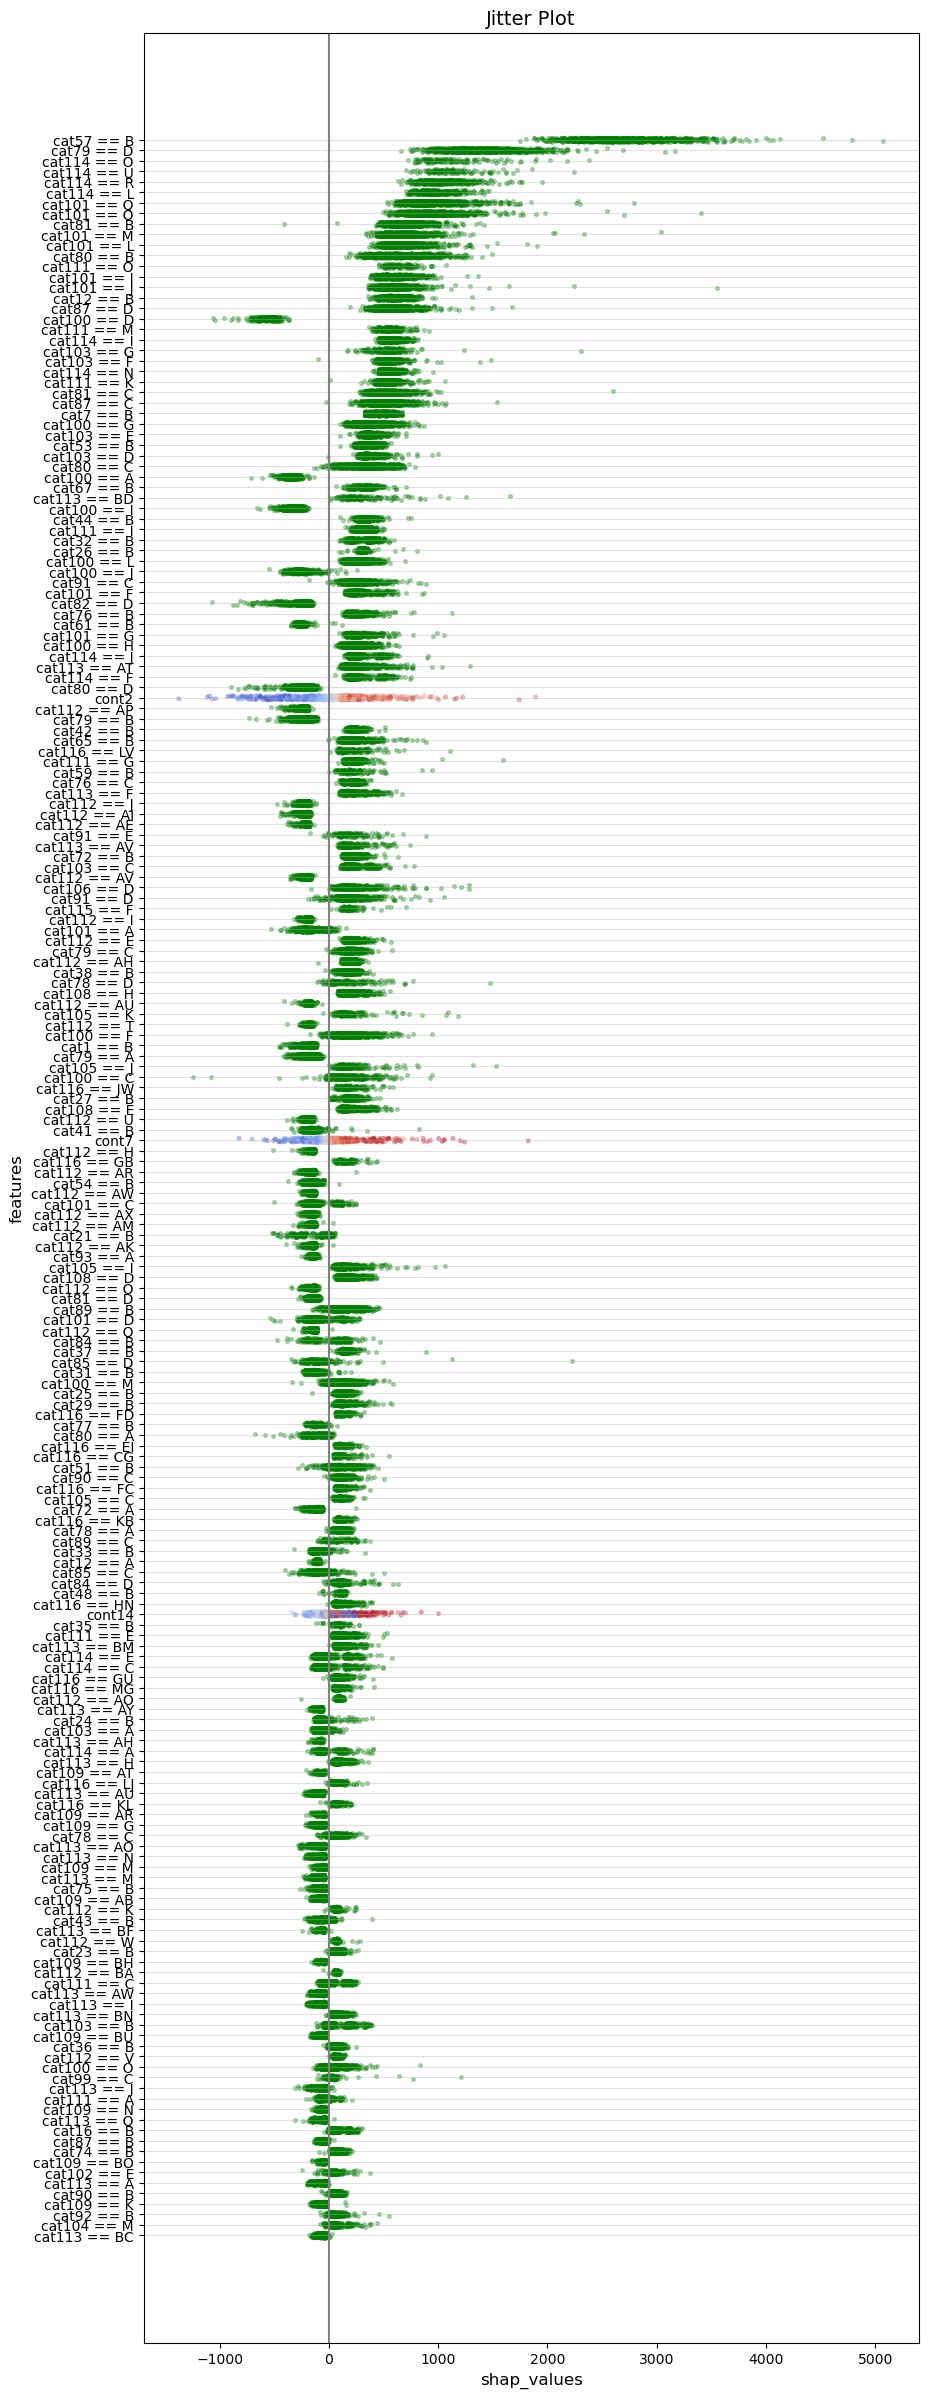

In [15]:
my_beeswarm(train_df.iloc[train_indexes], features, shap_values, top_k=200, figsize=(10, 30))

In [ ]:
# initialize Pool

train_features = features + [f+'_cat' for f in cont_as_cat] + [f+'_cont' for f in cat_as_cont]

train_pool = Pool(train_df.iloc[train_indexes][train_features],
                  train_df.iloc[train_indexes][target],
                  cat_features=cat_features+[f+'_cat' for f in cont_as_cat])
val_pool = Pool(train_df.iloc[valid_indexes][train_features],
                train_df.iloc[valid_indexes][target],
                cat_features=cat_features+[f+'_cat' for f in cont_as_cat])
test_pool = Pool(test_df[train_features],
                 cat_features=cat_features+[f+'_cat' for f in cont_as_cat])

model = CatBoostRegressor(
    loss_function='RMSE',  # Основная функция потерь (можно оставить стандартной)
    eval_metric=AsymmetricMSE(),  # Наша кастомная метрика для валидации
    verbose=100
)

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=True
)

In [ ]:
submission_df = pd.DataFrame({'target': model.predict(test_pool)})
submission_df.index.name = 'index'
submission_df.to_csv('submission_3.csv', index='index') 

In [ ]:
AsymmetricMSE().evaluate(approxes=model.predict(train_df.iloc[valid_indexes][features].to_numpy()),
                         target=train_df.iloc[valid_indexes][target].to_numpy(),
                         weight=None)

In [ ]:
AsymmetricMSE().evaluate(approxes=model.predict(train_df.iloc[valid_indexes][train_features].to_numpy()),
                         target=train_df.iloc[valid_indexes][target].to_numpy(),
                         weight=None)

In [ ]:
215470769546.5207 - 275312382078.945

In [30]:
train_df['log_target'] = np.log1p(train_df['target'])
train_df['target_rank'] = train_df['target'].argsort().argsort()
train_df['target_rank_100'] = train_df['target_rank']//100

In [ ]:
fig, axes = plt.subplots(3)
axes[0].hist(train_df['target'], bins=1000)
axes[1].scatter(train_df['target'].argsort().argsort(), y=train_df['target'], c=train_df['target_rank_100'])
axes[2].hist(train_df['log_target'], bins=1000);
# fig.show()

In [ ]:
sns.pairplot(train_df[cont_features+['target', 'log_target']].sample(500))
plt.show()


## 3) Понижение размерности (5 баллов)
Выбрать разумные векторы, представляющие объекты, и перевести их в 2D / 3D с помощью t-SNE / UMAP; постараться извлечь из этого выгоду для решения задачи; также можно попробовать понизить размерность до k > 3 и попробовать извлечь выгоду из этого; описать сделанное и увиденное;



In [ ]:
from openTSNE import TSNE
from umap import UMAP

In [50]:
emb_umap_shap = UMAP(
    n_components=2,
    n_jobs=8,
    n_neighbors=50,
    metric='euclidean',
    ).fit_transform(shap_values.values)

# emb_tsne = TSNE(n_components=2,
#                 n_jobs=8,
#                 perplexity=5,
#                 ).fit(emb_umap)

<Axes: >

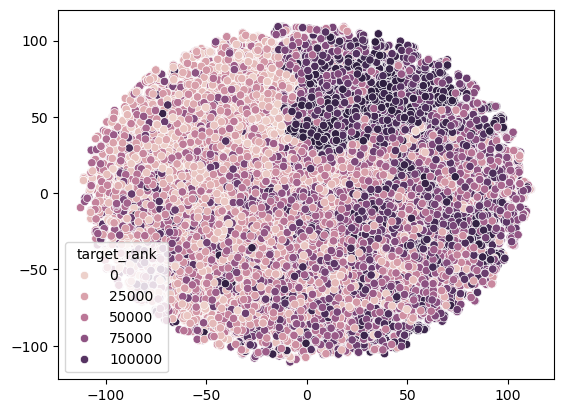

In [46]:
sns.scatterplot(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    hue=train_df.iloc[train_indexes]['target_rank']
    )

<Axes: >

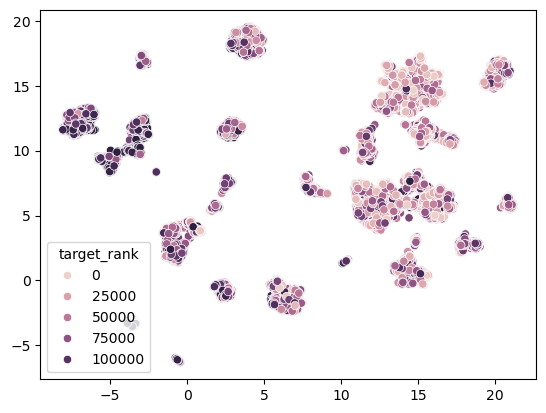

In [49]:
sns.scatterplot(
    x=emb_umap_shap[:, 0],
    y=emb_umap_shap[:, 1],
    hue=train_df.iloc[train_indexes]['target_rank']
    )

<Axes: >

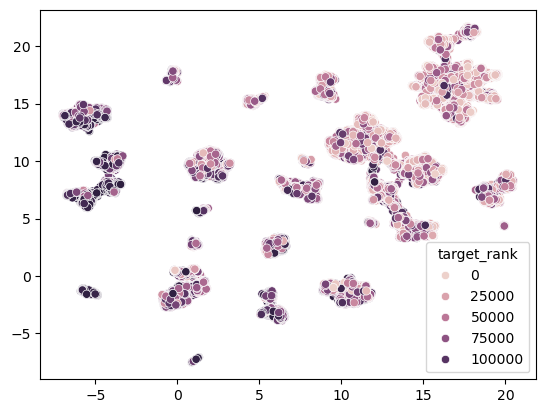

In [51]:
sns.scatterplot(
    x=emb_umap_shap[:, 0],
    y=emb_umap_shap[:, 1],
    hue=train_df.iloc[train_indexes]['target_rank']
    )

In [ ]:
sample_df = train_df.sample(5000)[cont_features+['target_rank_100']]
#.drop(columns=['target', 'target_rank_100', 'target_rank', 'log_target'])

In [20]:
model

In [ ]:
# embedding = TSNE(
#     # n_components=2,
#     # perplexity=30,
#     # early_exaggeration_iter=250,
#     # early_exaggeration=12,
#     # n_iter=10,
#     # exaggeration=4,
#     # initialization='pca',
#     metric='euclidean',
#     n_jobs=8,
#     verbose=True
# ).fit(sample_df[cont_features].values.astype(np.float32))


In [ ]:
# Сначала UMAP (сохраняет глобальную структуру)
umap_reduced = UMAP(n_components=30, random_state=42).fit_transform(sample_df.drop(columns='target_rank_100'))

# Затем t-SNE (улучшает локальные кластеры)
X_embedded = TSNE(n_components=2, random_state=42).fit(umap_reduced)

In [ ]:
sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=sample_df['target_rank_100'].astype(str),
    # hue_order=np.unique(tr_labels).astype(str)
    )
plt.gcf().set_size_inches(10, 10)
plt.show()

## Кластеризация

### Применим кластеризацию для отбора признаков:
- С помощью KMeans получим 5 кластеров
- Для каждого кластера посмотрим на среднее значение признака
- Возьмем только те признаки, средние значения которых, меняются в разных кластерах

Получим такой список: ['holy_spirit', 'postojka', 'baz200', 'fenistraline_length']

Построим TSNE немножко перебрав в ручную параметры на этих признаках и увидим пять кластеров, два из которых касаются друг друга. Улучшить этот результат увеличением и уменьшением числа признаков не получилось

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

data_with_clusters = pd.DataFrame(data_scaled, columns=X.columns)
data_with_clusters['cluster'] = cluster_labels

In [ ]:
data_with_clusters.groupby('cluster').mean().std(axis=0).sort_values(ascending=False).reset_index().rename(columns={'index': 'feature', 0: 'diff over clusters'})